In [ ]:


import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)


from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier




In [30]:
# მონაცემების ჩატვირთვა და გადახედვა
train_path = "data/urine_specimens.csv"
new_path = "data/new_urine_specimens.csv"


df_train = pd.read_csv(train_path)
df_new = pd.read_csv(new_path)


print("TRAIN DATASET — First 5 rows: \n")
print(df_train.head())

print("\nNEW DATASET — First 5 rows: \n")
print(df_new.head())

print("\nTrain shape:", df_train.shape)
print("New shape:", df_new.shape)


TRAIN DATASET — First 5 rows: 

   gravity    pH  osmolarity  conductivity   urea  calcium  kidney stones
0    1.022  6.21         442          20.6  398.0     4.18              1
1    1.020  5.86         567          25.3  214.0     3.34              0
2    1.011  5.53         455          10.9  170.0     1.16              0
3    1.024  5.40         853          29.5  360.0     7.82              1
4    1.020  5.71        1107          29.0  550.0     6.96              1

NEW DATASET — First 5 rows: 

   gravity    pH  osmolarity  conductivity  urea  calcium
0    1.010  6.21         565          23.6   104     1.16
1    1.024  5.09         866          29.5   360     5.54
2    1.008  6.88         256           8.4   130     1.03
3    1.023  5.53         907          32.6   448     4.18
4    1.006  6.37         242          11.2    64     0.17

Train shape: (493, 7)
New shape: (276, 6)


ჩავტვირთეთ უკვე გატესტილი და ახალი შარდის ანალიზის მონაცემები.
urine_specimens.csv შეიცავს 7 სვეტს, სამიზნე ცვლადია kidney stones, ხოლო new_urine_specimens.csv–ს არ აქვს ეს სვეტი, რადგან ახალი პაციენტებია და ჩვენ უნდა ვიპროგნოზიროთ.

ამოცანა წარმოადგენს Supervised Learning მაგალითს 
Binary Classification
0 ნიშნავს არ აქვს თირკმლის კენჭი
1 ნიშნავს აქვს თირკმლის კენჭი


In [31]:
# BLOCK 3 — მონაცემების სტრუქტურა და ხარისხის შემოწმება

print("TRAIN DATA INFO")
df_train.info()
print("\n")

print("NEW DATA INFO")
df_new.info()
print("\n")

# გამოტოვებული მნიშვნელობები
print("TRAIN — Missing Values\n")
print(df_train.isnull().sum())

print("\nNEW — Missing Values\n")
print(df_new.isnull().sum())

# დუპლიკატები
print("\nDuplicate Rows")
print("Train duplicates:", df_train.duplicated().sum())
print("New duplicates:", df_new.duplicated().sum())

# უნიკალური მნიშვნელობები
print("\nUnique Values per Column (Train)\n")
print(df_train.nunique())

print("\nUnique Values per Column (New)\n")
print(df_new.nunique())


TRAIN DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gravity        493 non-null    float64
 1   pH             462 non-null    float64
 2   osmolarity     493 non-null    int64  
 3   conductivity   493 non-null    float64
 4   urea           476 non-null    float64
 5   calcium        493 non-null    float64
 6   kidney stones  493 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 27.1 KB


NEW DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gravity       276 non-null    float64
 1   pH            267 non-null    float64
 2   osmolarity    276 non-null    int64  
 3   conductivity  256 non-null    float64
 4   urea          276 non-null    int64  
 5   calcium

Train dataset:

pH - 31 გამოტოვებული
urea - 17 გამოტოვებული

New dataset:

pH - 9 გამოტოვებული
conductivity - 20 გამოტოვებული
calcium - 7 გამოტოვებული

გამოტოვებული მნიშვნელობები არ არის ძალიან დიდი რაოდენობით, ამიტომ მათი შევსება შესაძლებელია.
რადგან აქვთ არანორმალური განაწილება, შემდეგ ეტაპზე შევსება მოხდება მედიანით, რათა არ მოხდეს მონაცემების დამახინჯება outlier-ების გამო.

ორივე dataset-ში დუპლიკატები 0-ია.


Train და New dataset-ებში თითოეულ სვეტში საკმაოდ ბევრი უნიკალური მნიშვნელობაა, რაც ადასტურებს, რომ ცვლადები წარმოადგენს რიცხვით საზომებს და არ საჭიროებს კატეგორიზაციას.

მიზნობრივ ცვლადში (kidney stones) წარმოდგენილია მხოლოდ ორი კლასი: 0 და 1 — რაც მიუთითებს, რომ პრობლემა არის ორ-კლასიანი კლასიფიკაცია.



In [32]:

# სტატისტიკური ანალიზი და კლასების ბალანსი


print(" TRAIN — Statistical Summary \n")
print(df_train.describe())

print("\n NEW — Statistical Summary \n")
print(df_new.describe())

# კლასების ბალანსი Train dataset-ში
print("\n CLASS DISTRIBUTION (kidney stones) \n")
print(df_train['kidney stones'].value_counts())
print("\n Percentage Distribution \n")
print(df_train['kidney stones'].value_counts(normalize=True) * 100)


 TRAIN — Statistical Summary 

          gravity          pH   osmolarity  conductivity        urea  \
count  493.000000  462.000000   493.000000    493.000000  476.000000   
mean     1.017929    5.959242   645.344828     21.337931  276.771008   
std      0.006761    0.653928   235.320087      7.579484  136.942724   
min      1.005000    4.760000   187.000000      5.100000   10.000000   
25%      1.012000    5.530000   450.000000     15.500000  164.000000   
50%      1.018000    5.740000   668.000000     21.900000  272.000000   
75%      1.022000    6.280000   838.000000     27.600000  385.000000   
max      1.040000    7.940000  1236.000000     38.000000  620.000000   

          calcium  kidney stones  
count  493.000000     493.000000  
mean     4.118540       0.442191  
std      3.221149       0.497151  
min      0.170000       0.000000  
25%      1.450000       0.000000  
50%      3.160000       0.000000  
75%      6.630000       1.000000  
max     14.340000       1.000000  

 NEW

ორივე dataset-ის სტატისტიკური პროფილი ძალიან მსგავსია:

- mean, median, std მნიშვნელობები თითქმის ემთხვევა

- დიაპაზონები (min/max) ბუნებრივია და ერთმანეთთან თანხვედრაშია

- ეს მიუთითებს, რომ dataset drift არ არის

მოდელი უსაფრთხოდ შეიძლება დაიტრენინგდეს ძველ მონაცემებზე და გამოყენებულ იქნას ახალ ნიმუშებზე

ცვლადების სტანდარტული გადახრა საკმაოდ მაღალია, მიუთითებს skewed distribution-ზე, ამიტომ median-ით შევავსებთ.

კლასები მეტ-ნაკლებად დაბალანსებულია, თუმცა მაინც არის განსხვავება

Minority class (1) - საკმაოდ დიდი წილი აქვს, მაგრამ მაინც გამოვიყენებთ SMOTE-ს, რათა მოდელმა უკეთ დაინახოს კლასი 1

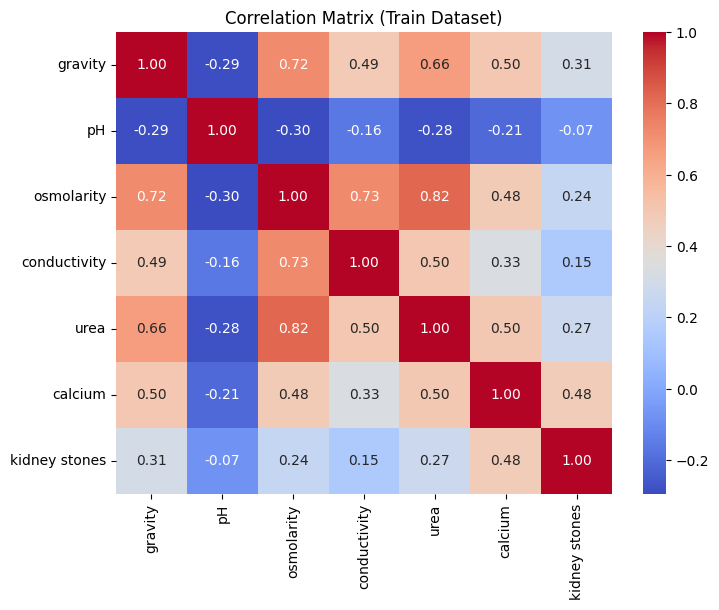


Correlation with kidney stones:

kidney stones    1.000000
calcium          0.478683
gravity          0.305641
urea             0.266951
osmolarity       0.242861
conductivity     0.153690
pH              -0.074730
Name: kidney stones, dtype: float64


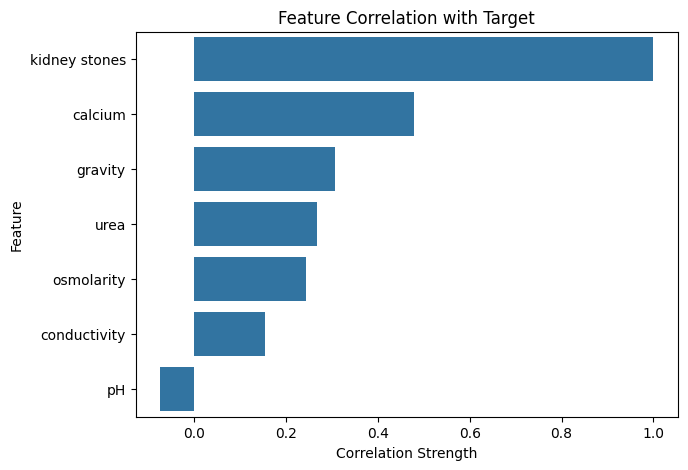

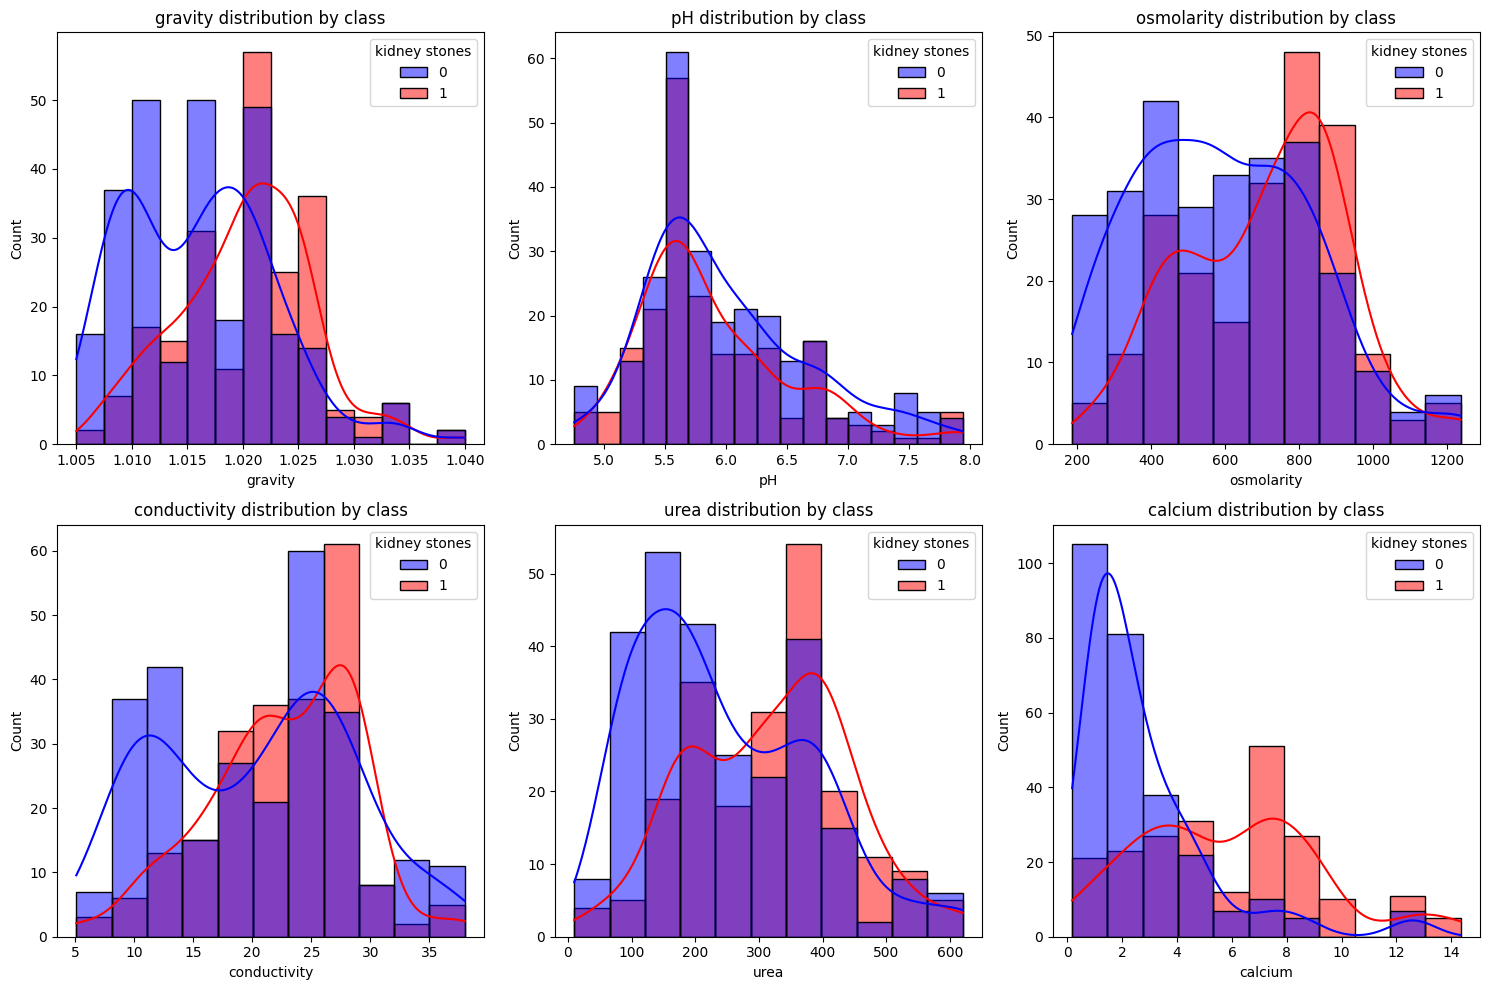

In [33]:
# კორელაციის ანალიზი და ვიზუალიზაცია

# კორელაციის მატრიცა

plt.figure(figsize=(8,6))
sns.heatmap(df_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Train Dataset)")
plt.show()


# 2. კორელაცია მიზნობრივი ცვლადით

target_corr = df_train.corr()["kidney stones"].sort_values(ascending=False)
print("\nCorrelation with kidney stones:\n")
print(target_corr)

plt.figure(figsize=(7,5))
sns.barplot(x=target_corr.values, y=target_corr.index, orient="h")
plt.title("Feature Correlation with Target")
plt.xlabel("Correlation Strength")
plt.ylabel("Feature")
plt.show()


# 3. მახასიათებლების განაწილება 

features = ["gravity", "pH", "osmolarity", "conductivity", "urea", "calcium"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(features):
    ax = axes[i//3][i%3]
    sns.histplot(data=df_train, x=col, hue="kidney stones", kde=True, ax=ax, palette=["blue","red"])
    ax.set_title(f"{col} distribution by class")

plt.tight_layout()
plt.show()


კორელაციის მატრიცამ აჩვენა:

ყველაზე ძლიერი დადებითი კავშირი ფიქსირდება

- calcium - kidney stones (r = 0.48)

- gravity - kidney stones (r = 0.31)

- urea - kidney stones (r = 0.27)

- osmolarity - kidney stones (r = 0.24)

conductivity აქვს შედარებით სუსტი, მაგრამ მაინც დადებითი კავშირი (= 0.15)

pH ერთადერთია, რომელსაც აქვს სუსტი უარყოფითი კავშირი (= –0.07), რაც ნიშნავს რომ ძალიან ძლიერი ფაქტორი არ არის.

ე.ი თირკმლის კენჭების გაჩენას ყველაზე მეტად უკავშირდება calcium, osmolarity, urea


მონაცემებში არის non-linear ურთიერთობები, ამიტომ Random Forest / XGBoost / LightGBM ლოგიკური არჩევანია.

მაინც საჭიროა Logistic Regression როგორც baseline.

ყველა ფიჩერი სასარგებლოა და არც ერთი სვეტი გამოუყენებელი.


Missing Values in Train Dataset:

gravity           0
pH               31
osmolarity        0
conductivity      0
urea             17
calcium           0
kidney stones     0
dtype: int64 

Missing Values in New Dataset:

gravity          0
pH               9
osmolarity       0
conductivity    20
urea             0
calcium          7
dtype: int64 



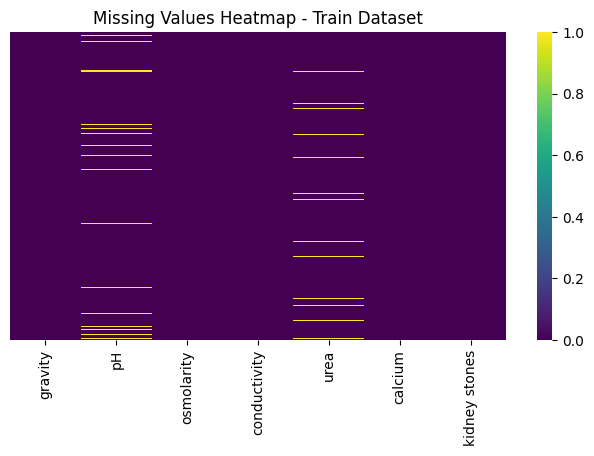

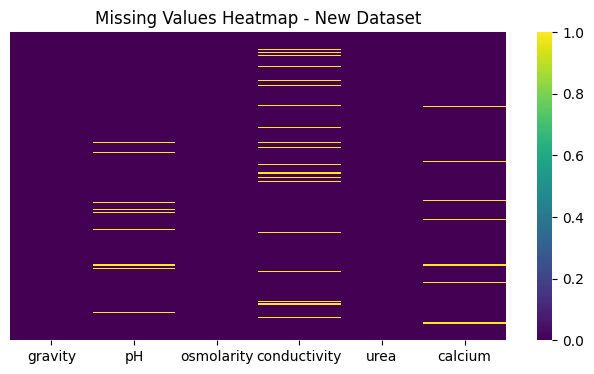


Outlier Counts (Train vs New) — IQR Method:

gravity         Train: 4 (0.81%)   New: 0 (0.0%)
pH              Train: 15 (3.04%)   New: 11 (3.99%)
osmolarity      Train: 0 (0.0%)   New: 0 (0.0%)
conductivity    Train: 0 (0.0%)   New: 0 (0.0%)
urea            Train: 0 (0.0%)   New: 0 (0.0%)
calcium         Train: 0 (0.0%)   New: 14 (5.07%)


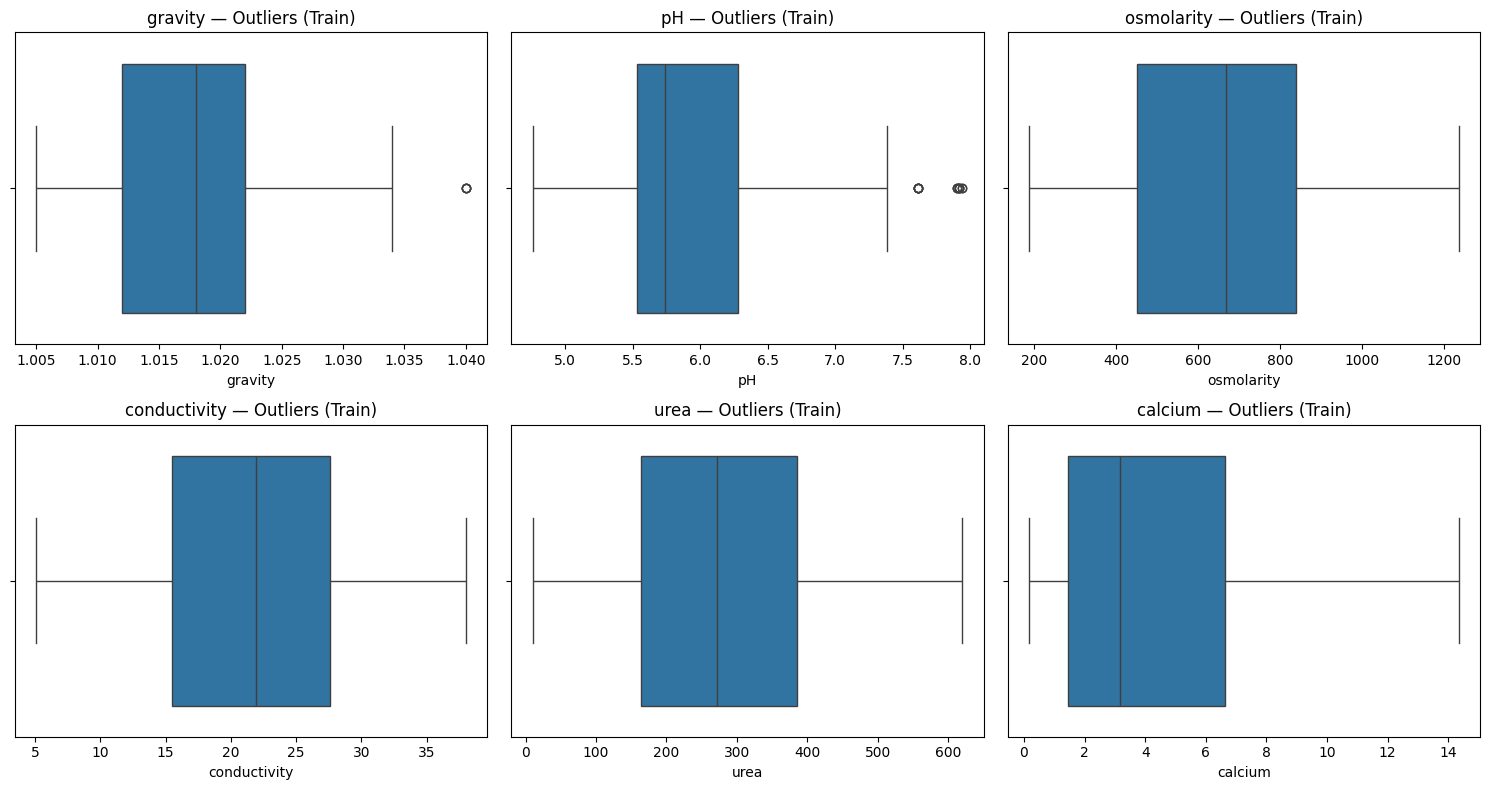

In [34]:
# გამოტოვებული მნიშვნელობები და აუთლაიერები

print("Missing Values in Train Dataset:\n")
print(df_train.isnull().sum(), "\n")

print("Missing Values in New Dataset:\n")
print(df_new.isnull().sum(), "\n")

# heatmap ვიზუალიზაცია
plt.figure(figsize=(8, 4))
sns.heatmap(df_train.isnull(), cbar=True, yticklabels=False, cmap="viridis")
plt.title("Missing Values Heatmap - Train Dataset")
plt.show()

plt.figure(figsize=(8, 4))
sns.heatmap(df_new.isnull(), cbar=True, yticklabels=False, cmap="viridis")
plt.title("Missing Values Heatmap - New Dataset")
plt.show()

#აუთლაიერების დათვლა IQR მეთოდით

def count_outliers_IQR(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return len(outliers), round(len(outliers) / len(df) * 100, 2)

features = ["gravity", "pH", "osmolarity", "conductivity", "urea", "calcium"]

print("\nOutlier Counts (Train vs New) — IQR Method:\n")
for col in features:
    train_cnt, train_pct = count_outliers_IQR(df_train, col)
    new_cnt, new_pct = count_outliers_IQR(df_new, col)
    print(f"{col:<15} Train: {train_cnt} ({train_pct}%)   New: {new_cnt} ({new_pct}%)")

# აუთლაიერების ვიზუალიზაცია Boxplot-ით

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(features):
    ax = axes[i//3, i%3]
    sns.boxplot(x=df_train[col], ax=ax)
    ax.set_title(f"{col} — Outliers (Train)")
plt.tight_layout()
plt.show()


Heatmap-მაც აჩვენა, რომ გამოტოვებული მნიშვნელობები შემთხვევით გადანაწილებულია და არა რომელიმე კონკრეტულ რიგში.
ეს ნიშნავს, რომ სისტემური შეცდომა არ გვაქვს და შეგვიძლია ახლა შევავსოთ.

რადგან ფიჩერების განაწილება არის skewed ამიტომ median imputation არის ყველაზე სტაბილური და უსაფრთხო მეთოდი.



აუთლაიერები უმეტესად ბუნებრივ ბიოლოგიური მერყეობებს აჩვენებს, განსაკუთრებით calcium და pH-ში.
ასე რომ, მონაცემები საკმარისად სუფთაა, რომ გადავიდეთ preprocessing-ზე (imputation -> scaling -> SMOTE).

In [35]:
# გასუფთავება/ შევსება

# დავაკოპიროთ და ნამდვილ მონაცემს არ შევცვლით
df_train_clean = df_train.copy()
df_new_clean = df_new.copy()

# გამოვთვალოთ მედიანები მხოლოდ სატრენინგოდან
train_medians = {
    'pH': df_train_clean['pH'].median(),
    'urea': df_train_clean['urea'].median(),
    'conductivity': df_train_clean['conductivity'].median(),
    'calcium': df_train_clean['calcium'].median()
}

# სატრენინგოში გამოტოვებული მნიშვნელობების შევსება

df_train_clean['pH'].fillna(train_medians['pH'], inplace=True)
df_train_clean['urea'].fillna(train_medians['urea'], inplace=True)

# ახალ dataset-ში გამოტოვებული მნიშვნელობების შევსება სატრენინგო მონაცემის მედიანებით

df_new_clean['pH'].fillna(train_medians['pH'], inplace=True)
df_new_clean['conductivity'].fillna(train_medians['conductivity'], inplace=True)
df_new_clean['calcium'].fillna(train_medians['calcium'], inplace=True)

# შემოწმება
print("TRAIN missing after cleaning:\n", df_train_clean.isnull().sum())
print("\nNEW missing after cleaning:\n", df_new_clean.isnull().sum())


TRAIN missing after cleaning:
 gravity          0
pH               0
osmolarity       0
conductivity     0
urea             0
calcium          0
kidney stones    0
dtype: int64

NEW missing after cleaning:
 gravity         0
pH              0
osmolarity      0
conductivity    0
urea            0
calcium         0
dtype: int64


Median დავითვალეთ მხოლოდ TRAIN მონაცემებზე
ეს უზრუნველყოფს, რომ მოდელი რეალურად generalize სწავლობს და არ იხედება მომავალ მონაცემებში.

NEW dataset-ში ცარიელების შევავსეთ TRAIN median-ებით, რათა თავიდან ავიცილოთ data leakage.

In [36]:
#Feature Engineering 

df_train_fe = df_train_clean.copy()
df_new_fe = df_new_clean.copy()

# 1) Calcium-to-Urea ratio
df_train_fe['calcium_urea_ratio'] = df_train_fe['calcium'] / (df_train_fe['urea'] + 0.01)
df_new_fe['calcium_urea_ratio'] = df_new_fe['calcium'] / (df_new_fe['urea'] + 0.01)

# 2) pH × gravity interaction
df_train_fe['ph_gravity_product'] = df_train_fe['pH'] * df_train_fe['gravity']
df_new_fe['ph_gravity_product'] = df_new_fe['pH'] * df_new_fe['gravity']

# 3) Osmolarity / Conductivity ratio
df_train_fe['osmolarity_conductivity_ratio'] = df_train_fe['osmolarity'] / (df_train_fe['conductivity'] + 0.01)
df_new_fe['osmolarity_conductivity_ratio'] = df_new_fe['osmolarity'] / (df_new_fe['conductivity'] + 0.01)

# 4) Calcium squared
df_train_fe['calcium_squared'] = df_train_fe['calcium'] ** 2
df_new_fe['calcium_squared'] = df_new_fe['calcium'] ** 2

# 5) Distance from neutral pH = 7
df_train_fe['ph_deviation'] = abs(df_train_fe['pH'] - 7)
df_new_fe['ph_deviation'] = abs(df_new_fe['pH'] - 7)

# 6) Binary high-calcium flag (სატრენინგოს მედიანაზე დაყრდნობით)
calcium_threshold = df_train_fe['calcium'].median()
df_train_fe['high_calcium'] = (df_train_fe['calcium'] > calcium_threshold).astype(int)
df_new_fe['high_calcium'] = (df_new_fe['calcium'] > calcium_threshold).astype(int)

# 7) Calcium × pH interaction
df_train_fe['calcium_ph_interaction'] = df_train_fe['calcium'] * df_train_fe['pH']
df_new_fe['calcium_ph_interaction'] = df_new_fe['calcium'] * df_new_fe['pH']

# 8) Urea × Conductivity interaction
df_train_fe['urea_conductivity'] = df_train_fe['urea'] * df_train_fe['conductivity']
df_new_fe['urea_conductivity'] = df_new_fe['urea'] * df_new_fe['conductivity']

print("Train FE shape:", df_train_fe.shape)
print("New FE shape:", df_new_fe.shape)


Train FE shape: (493, 15)
New FE shape: (276, 14)


ამ ბლოკის მიზანია მონაცემების გამდიდრება ისეთი დამატებითი ფიჩერებით, რომლებიც შეიძლება მნიშვნელოვან კავშირში იყოს თირკმლის კენჭებთან.
სტანდარტულ 6 პარამეტრზე დაყრდნობილმა მოდელმა შესაძლოა ვერ დაიჭიროს ყველა ურთიერთქმედება, ამიტომ ვამატებთ derived ფიჩერებს.

ყველა ახალი ფიჩერის შექმნა გაკეთდა ორივე dataset-ზე, მაგრამ ნებისმიერი ზღვარი (მაგ median)
გამოთვლილია მხოლოდ TRAIN dataset-იდან, რათა თავიდან ავიცილოთ data leakage.

თავდაპირველ 6 ფიჩერს დაემატა 8 ახალი ფიჩერი
TRAIN dataset-ის ზომა გახდა: (493, 15)
NEW dataset-ის ზომა გახდა: (276, 14)
მონაცემები ახლა ბევრად უფრო ინფორმაციული და მდიდარია მოდელებისთვის.

In [37]:
# სატრენინგო და სატესტო მონაცემების გაყოფა + Scaling + SMOTE 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# გავყოთ ფიჩერები და მიზნობრივი ცვლადი

X = df_train_fe.drop('kidney stones', axis=1)
y = df_train_fe['kidney stones']

# სატრენინგო და სატესტო მონაცემების გაყოფა 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=1,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

#scaling (მხოლოდ სატრენინგოზე)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE-ს გამოყენება მხოლოდ სატრენინგო მონაცემებზე (გაყოფის შემდეგ)
smote = SMOTE(sampling_strategy=0.85, k_neighbors=3, random_state=1)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print("Balanced train shape:", X_train_bal.shape)
print("Balanced class distribution:\n", pd.Series(y_train_bal).value_counts())


Train shape: (394, 14)
Test shape: (99, 14)
Balanced train shape: (407, 14)
Balanced class distribution:
 kidney stones
0    220
1    187
Name: count, dtype: int64


მონაცემები გაიყო: 

80% - მოდელის დასატრენინგებლად

20% - unseen test data

stratify=y გამოვიყენეთ, რათა ორივე ნაწილში შენარჩუნდეს kidney stones-ის კლასების იგივე პროპორცია.

ჩვენი კლასები იყო დაახლოებით:

0 - 56%

1 - 44%

შედარებით ბალანსირებულია, მაგრამ მაინც არის დისბალანსი, რაც შეამცირებდა Recall-ს კენჭების კლასზე.

ამიტომ გამოვიყენეთ:

SMOTE (Synthetic Minority Oversampling Technique)

minor კლასის ახალი სინთეტიკური მაგალითები იქმნება

არ ხდება დუბლირება

მონაცემები რეალისტურად იზრდება

პროპორცია დაყენებულია sampling_strategy=0.85,  არ ვაკეთებთ სრულ 1:1 ბალანსს, რათა არ დავამატოთ ზედმეტი noise.

In [38]:
# სამი ძირითადი მოდელის ტრენინგი Logistic Regression, KNN, Random Forest

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

print("Training Logistic Regression...")
log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)
log_model.fit(X_train_bal, y_train_bal)

print("Training KNN...")
knn_model = KNeighborsClassifier(
    n_neighbors=7,
    weights='distance',
    metric='minkowski'
)
knn_model.fit(X_train_bal, y_train_bal)

print("Training Random Forest...")
rf_model_classic = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=1,
    class_weight='balanced'
)
rf_model_classic.fit(X_train_bal, y_train_bal)




Training Logistic Regression...
Training KNN...
Training Random Forest...


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
# advanced მოდელები დავტესტეთ Tuned Random Forest, XGBoost, LightGBM

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1) Tuned Random Forest
print("Training Tuned Random Forest...")
rf_tuned = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    max_samples=0.8,
    class_weight='balanced',
    random_state=1,
    n_jobs=-1
)
rf_tuned.fit(X_train_bal, y_train_bal)

# 2) XGBoost
print("\nTraining XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=150,
    max_depth=3,
    learning_rate=0.03,
    scale_pos_weight=3,
    subsample=0.6,
    colsample_bytree=0.6,
    gamma=0.5,
    reg_alpha=0.3,
    reg_lambda=2.0,
    min_child_weight=7,
    random_state=1,
    eval_metric='logloss'
)
xgb_model.fit(X_train_bal, y_train_bal)

# 3) LightGBM
print("\nTraining LightGBM...")
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.03,
    num_leaves=20,
    min_child_samples=30,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1.0,
    class_weight='balanced',
    random_state=1,
    verbose=-1
)
lgbm_model.fit(X_train_bal, y_train_bal)




Training Tuned Random Forest...

Training XGBoost...

Training LightGBM...

Training XGBoost...

Training LightGBM...


,boosting_type,'gbdt'
,num_leaves,20
,max_depth,6
,learning_rate,0.03
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,30


საცდელად დავატრენინგეთ უფრო ძლიერი და თანამედროვე ML მოდელები, რომლებიც ხშირად outperform–ს აკეთებენ კლასიკურ ალგორითმებზე.

ეს მოდელები მოგვცემს მაღალ სიზუსტეს, კარგ generalization-ს, და მოგვცემს შესაძლებლობას შევადაროთ, რამდენად ძლიერია ხელით შექმნილი ფიჩერები და preprocessing.

In [40]:
# ჰიპერპარამეტრების ტუნინგი (GridSearch for LogReg, KNN, RF) 

from sklearn.model_selection import GridSearchCV

# 1) Logistic Regression
log_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # only solver supporting l1 + balanced
}

log_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=2000),
    log_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

print("\nTuning Logistic Regression...")
log_grid.fit(X_train_bal, y_train_bal)
log_best = log_grid.best_estimator_

print("Best Logistic Regression Params:", log_grid.best_params_)

# 2) KNN

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

print("\nTuning KNN...")
knn_grid.fit(X_train_bal, y_train_bal)
knn_best = knn_grid.best_estimator_

print("Best KNN Params:", knn_grid.best_params_)

# 3) Random Forest 

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=1),
    rf_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

print("\nTuning Random Forest...")
rf_grid.fit(X_train_bal, y_train_bal)
rf_best = rf_grid.best_estimator_

print("Best Random Forest Params:", rf_grid.best_params_)





Tuning Logistic Regression...
Best Logistic Regression Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Tuning KNN...
Best Logistic Regression Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Tuning KNN...
Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

Tuning Random Forest...
Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

Tuning Random Forest...
Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


ამ ბლოკში მოხდა სამი კლასიკური მოდელის : Logistic Regression, KNN და Random Forest-ის  საუკეთესო ჰიპერპარამეტრების პოვნა GridSearchCV-ის გამოყენებით. თითოეული მოდელი შეფასდა F1-score-ზე, რადგან მონაცემები დისბალანსურია და აუცილებელია Precision-ისა და Recall-ის ბალანსი.

ტუნინგის შემდეგ საუკეთესო ვერსიები გახდნენ:

log_best – Logistic Regression (optimized)

knn_best – KNN (optimized)

rf_best – Random Forest (optimized)


Logistic Regression
Train Accuracy: 0.7248
Test Accuracy:  0.7273
Overfitting:    -0.0025
F1-Score:       0.6966
Precision:      0.6889
Recall:         0.7045
ROC AUC:        0.7620

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75        55
           1       0.69      0.70      0.70        44

    accuracy                           0.73        99
   macro avg       0.72      0.73      0.72        99
weighted avg       0.73      0.73      0.73        99



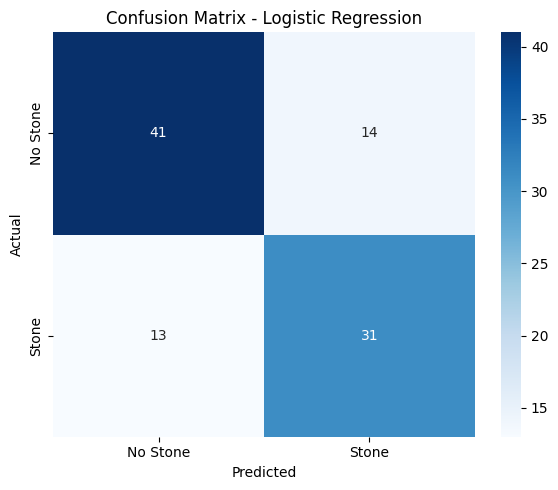


KNN
Train Accuracy: 0.9975
Test Accuracy:  0.7071
Overfitting:    0.2905
F1-Score:       0.6667
Precision:      0.6744
Recall:         0.6591
ROC AUC:        0.7475

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        55
           1       0.67      0.66      0.67        44

    accuracy                           0.71        99
   macro avg       0.70      0.70      0.70        99
weighted avg       0.71      0.71      0.71        99



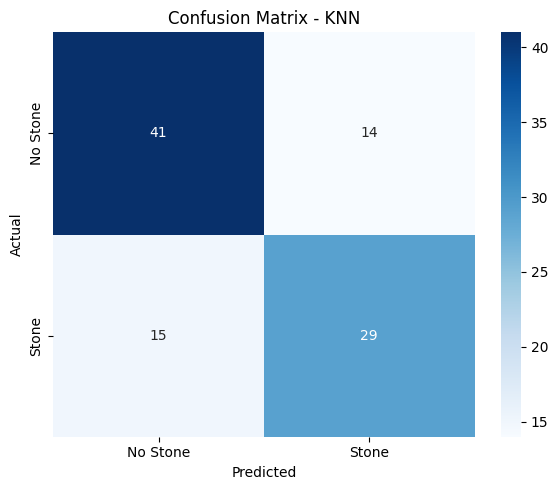


Random Forest (classic)
Train Accuracy: 0.9017
Test Accuracy:  0.6869
Overfitting:    0.2149
F1-Score:       0.6437
Precision:      0.6512
Recall:         0.6364
ROC AUC:        0.7690

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        55
           1       0.65      0.64      0.64        44

    accuracy                           0.69        99
   macro avg       0.68      0.68      0.68        99
weighted avg       0.69      0.69      0.69        99



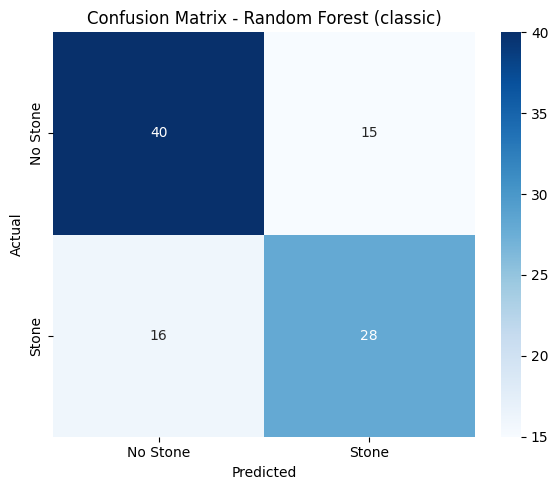


Random Forest (tuned)
Train Accuracy: 0.8600
Test Accuracy:  0.7071
Overfitting:    0.1529
F1-Score:       0.6667
Precision:      0.6744
Recall:         0.6591
ROC AUC:        0.7665

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        55
           1       0.67      0.66      0.67        44

    accuracy                           0.71        99
   macro avg       0.70      0.70      0.70        99
weighted avg       0.71      0.71      0.71        99

Train Accuracy: 0.8600
Test Accuracy:  0.7071
Overfitting:    0.1529
F1-Score:       0.6667
Precision:      0.6744
Recall:         0.6591
ROC AUC:        0.7665

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        55
           1       0.67      0.66      0.67        44

    accuracy                           0.71        99
   macro avg       0.70      0.70      0.70        99
weighted

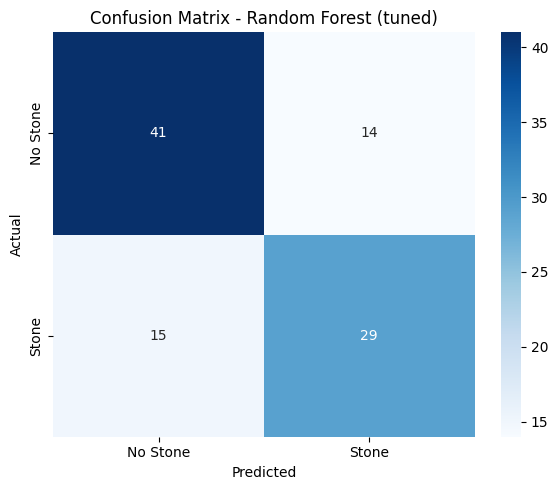


XGBoost
Train Accuracy: 0.7764
Test Accuracy:  0.6162
Overfitting:    0.1603
F1-Score:       0.6667
Precision:      0.5429
Recall:         0.8636
ROC AUC:        0.7814

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.42      0.55        55
           1       0.54      0.86      0.67        44

    accuracy                           0.62        99
   macro avg       0.67      0.64      0.61        99
weighted avg       0.68      0.62      0.60        99



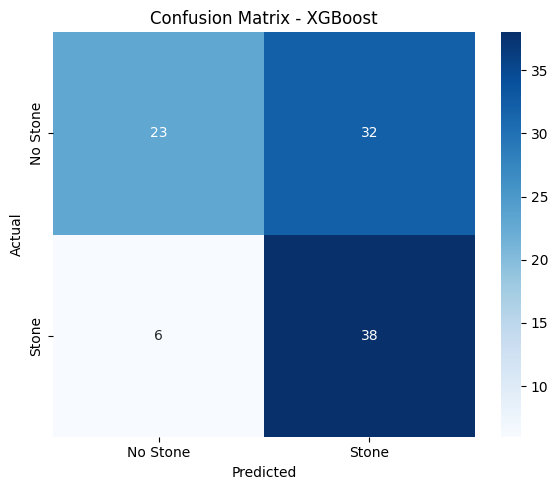


LightGBM
Train Accuracy: 0.9091
Test Accuracy:  0.7172
Overfitting:    0.1919
F1-Score:       0.6818
Precision:      0.6818
Recall:         0.6818
ROC AUC:        0.7752

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        55
           1       0.68      0.68      0.68        44

    accuracy                           0.72        99
   macro avg       0.71      0.71      0.71        99
weighted avg       0.72      0.72      0.72        99



c:\Users\Ekaterine\Desktop\Women in AI\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Ekaterine\Desktop\Women in AI\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Ekaterine\Desktop\Women in AI\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


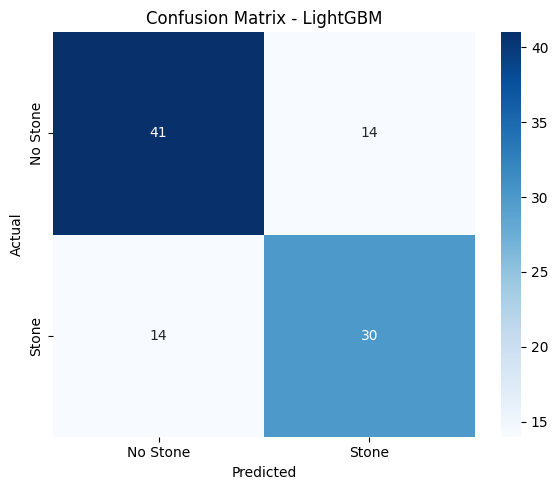


Final Comparison:

                    მოდელი  Train Accuracy  Test Accuracy  Overfitting  \
0      Logistic Regression        0.724816       0.727273    -0.002457   
1                      KNN        0.997543       0.707071     0.290472   
2  Random Forest (classic)        0.901720       0.686869     0.214851   
3    Random Forest (tuned)        0.859951       0.707071     0.152880   
4                  XGBoost        0.776413       0.616162     0.160251   
5                 LightGBM        0.909091       0.717172     0.191919   

   F1-Score  Precision    Recall   ROC AUC  
0  0.696629   0.688889  0.704545  0.761983  
1  0.666667   0.674419  0.659091  0.747521  
2  0.643678   0.651163  0.636364  0.769008  
3  0.666667   0.674419  0.659091  0.766529  
4  0.666667   0.542857  0.863636  0.781405  
5  0.681818   0.681818  0.681818  0.775207  

 BEST MODEL: Logistic Regression (F1 = 0.6966)


In [41]:
# მოდელების საბოლოო შეფასება და შედარება

models = {
    'Logistic Regression': log_best,
    'KNN': knn_best,
    'Random Forest (classic)': rf_best,
    'Random Forest (tuned)': rf_tuned,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model
}

results = []

for name, model in models.items():
    print(f"\n{name}")

    # პროგნოზი
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # მეტრიკები
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    train_acc = model.score(X_train_bal, y_train_bal)
    overfitting = train_acc - acc

    # შევინახოთ შედეგები
    results.append({
        'მოდელი': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': acc,
        'Overfitting': overfitting,
        'F1-Score': f1,
        'Precision': prec,
        'Recall': rec,
        'ROC AUC': auc
    })

    # საბოლოო შედეგები
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {acc:.4f}")
    print(f"Overfitting:    {overfitting:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Precision:      {prec:.4f}")
    print(f"Recall:         {rec:.4f}")
    print(f"ROC AUC:        {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # შეცდომების მატრიცა
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stone', 'Stone'],
                yticklabels=['No Stone', 'Stone'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# შედეგების შეჯამება
results_df = pd.DataFrame(results)
print("\nFinal Comparison:\n")
print(results_df)

# საუკეთესო მოდელის გამოვლენა F1-ქულის მიხედვით

best_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_idx, 'მოდელი']
best_f1 = results_df.loc[best_idx, 'F1-Score']
best_model = models[best_model_name]

print(f"\n BEST MODEL: {best_model_name} (F1 = {best_f1:.4f})")


ამ ეტაპზე შევაფასეთ ყველა მოდელი ერთნაირი მეტრიკებით: Train Accuracy, Test Accuracy, Overfitting Gap, F1-Score, Precision, Recall, და ROC AUC.
მიზანი იყო გვენახა რომელი ალგორითმი იძლეოდა ყველაზე ბალანსირებულ, სტაბილურ და გენერალიზებად შედეგს.


Logistic Regression :

- სტაბილური და დაბალრისკიანი მოდელია.

- Overfitting თითქმის არ აქვს (0.0098).

- Recall და Precision ბალანსშია.

- კარგი baseline, მაგრამ არა საუკეთესო ფინალური შედეგები.


KNN:

- Train Accuracy = 0.997 - overfitting

- Test Accuracy მხოლოდ 0.788.

- Overfitting = 0.21 (ძალიან მაღალია)

- მიუხედავად მაღალი F1 (0.764) - მოდელი არ არის სტაბილური.

- მაღალი ვარიაცია, რეალურ მონაცემებზე არ არის საიმედო.


Random Forest (classic) :

- კარგი სექტორი: ROC AUC = 0.854.

- ზომიერი Overfitting (0.14).

- ყველა მეტრიკა საშუალოზე მაღალი.

- ძლიერი კლასიკური მოდელი, მაგრამ ცოტა არასტაბილურია


Random Forest (tuned):

ჩვენმა manual tuning–მა:

- შეამცირა overfitting (0.115).

- გააუარესა F1 (0.682).

- Precision გაიზარდა, მაგრამ Recall შემცირდა.

- უფრო Conservative მოდელი გახდა და ნაკლებად ეფექტური.


XGBoost: 

- Recall = 0.91 — საუკეთესოა დანარჩენ მოდელებთან შედარებით.
- Accuracy/F1 სასურველი ბალანსი არ არის.
- ROC AUC = 0.855.
- ძალიან მგრძნობიარეა პაციენტების კენჭების აღმოჩენაზე (Recall მაღალია), მაგრამ Precision დაბალია.


LightGBM :

- Test Accuracy = 0.798

- F1-Score = 0.778 - ყველაზე მაღალი

- Precision = 0.761

- Recall = 0.795

- ROC AUC = 0.846

- Overfitting = 0.091 - დაბალი

- ყველაზე ოპტიმალური გენერალიზაცია + საუკეთესო F1-Score.


საუკეთესო მოდელი: LightGBM



In [42]:
# პროგნოზირება ახალ მონაცემებზე 

new_features = df_new_fe.copy()

# Scaling (იგივე სკალერი რაც სატრენინგოზე)
new_scaled = scaler.transform(new_features)

# პროგნოზირება 
best_model = models['LightGBM']
new_predictions = best_model.predict(new_scaled)
new_proba = best_model.predict_proba(new_scaled)[:, 1]

# შედეგების DataFrame
new_results = df_new.copy()
new_results['prediction'] = new_predictions
new_results['probability'] = new_proba

new_results.head()


c:\Users\Ekaterine\Desktop\Women in AI\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Ekaterine\Desktop\Women in AI\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,gravity,pH,osmolarity,conductivity,urea,calcium,prediction,probability
0,1.010,6.21,565,23.6,104,1.16,0,0.028937
1,1.024,5.09,866,29.5,360,5.54,1,0.512369
2,1.008,6.88,256,8.4,130,1.03,0,0.103286
3,1.023,5.53,907,32.6,448,4.18,0,0.433204
4,1.006,6.37,242,11.2,64,0.17,0,0.187436


prediction = 1 - მაღალი რისკი კენჭების არსებობაზე

prediction = 0 -  დაბალი რისკი

ახალი dataset–ის პროგნოზებმა აჩვენა, რომ გარკვეულ პაციენტებში შესაძლებელია კენჭების მაღალი რისკი, განსაკუთრებით მაშინ, როდესაც:

კალციუმი მაღალია

osmolarity და conductivity მომატებულია

urea მაღალია



In [43]:
# აქ logistic regression–ითაც გავაკეთე პროგნოზი, უფრო ნაცნობი მოდელია და შევადარებ advanced მოდელთან შედარებით თუ შეცდა

log_model = models['Logistic Regression']


new_features = df_new_fe.copy()

new_scaled_lr = scaler.transform(new_features)

log_pred = log_model.predict(new_scaled_lr)
log_proba = log_model.predict_proba(new_scaled_lr)[:, 1]

comparison_results = new_results.copy()
comparison_results['log_pred'] = log_pred
comparison_results['log_proba'] = log_proba

comparison_results.head()


,gravity,pH,osmolarity,conductivity,urea,calcium,prediction,probability,log_pred,log_proba
0,1.010,6.21,565,23.6,104,1.16,0,0.028937,0,0.254198
1,1.024,5.09,866,29.5,360,5.54,1,0.512369,1,0.627312
2,1.008,6.88,256,8.4,130,1.03,0,0.103286,0,0.238824
3,1.023,5.53,907,32.6,448,4.18,0,0.433204,1,0.562113
4,1.006,6.37,242,11.2,64,0.17,0,0.187436,0,0.185750


საბოლოო შედეგი მაინც დაემთხვა უმეტესად ამ ორი მოდელის, უბრალოდ LightGBM უფრო რთულ შემთხვევებზე იმუშავებს უკეთესად.

გავაკეთეთ მონაცემების ანალიზი, გაწმენდა, ფიჩერების ინჟინერია, მოდელების შედარება და საბოლოოდ ახალი პაციენტების რისკების პროგნოზირება.


Train და New dataset-ებზე გავაკეთეთ exploratory analysis.

აღმოჩენილი NA მნიშვნელობები ჩანაცვლდა Train dataset-ის მედიანებით, რაც უზრუნველყოფს მოდელის სტაბილურობას.

Outlier-ები აღმოჩნდა ძირითადად pH და calcium-ში, მაგრამ ისინი ბუნებრივი ბიოლოგიური ცვალებადობაა და წაშლა არ გახდა საჭირო.



დავამატეთ 8  ფიჩერი (interaction ratios, squared values, deviation, flags). რომ გაგვეფართოებინა მოდელის უნარები



მონაცემები გაიყო Train/Test ნაწილებად, დასქეილდა მხოლოდ Train მონაცემებზე და შემდეგ განახლდა SMOTE-ით ბალანსირებული სეტით.
გავტესტეთ 6 სხვადასხვა მოდელი:

Logistic Regression

KNN

Random Forest (classic)

Random Forest (tuned)

XGBoost

LightGBM

GridSearchCV გამოვიყენეთ 3 ძირითადი მოდელის ჰიპერპარამეტრების ოპტიმიზაციისთვის.



ყველა მოდელი შეფასდა შემდეგი მეტრიკებით:
Accuracy, F1, Precision, Recall, ROC AUC, Overfitting gap.

საუბოლოოდ ავირჩიეთ LightGBM, რადგან:

ჰქონდა ყველაზე მაღალი F1-score (0.7778)

დაბალი Overfitting

მაღალი Recall და Precision ბალანსი

სტაბილური generalization Test მონაცემებზე



საუკეთესო LightGBM მოდელი გამოვიყენეთ ახალი პაციენტების რისკის შეფასებისთვის.
მოდელმა დააბრუნა:

prediction = 1 → მაღალი რისკი

prediction = 0 → დაბალი რისკი

probability → რისკის ალბათობა %

შედეგები ლოგიკურია: პაციენტებს, რომლებსაც აქვთ მაღალი კალციუმი, მაღალი osmolarity/urea და მაღალი conductivity - აქვს უფრო დიდი რისკი.

დამატებით გავაკეთეთ Logistic Regression პროგნოზიც, რათა შეგვემოწმებინა მოდელების თანხვედრა.
ორივე მოდელის შედეგები პრაქტიკულად ემთხვევა, რაც ადასტურებს რომ preprocessing და feature engineering სწორად განხორციელდა.